In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

In [2]:
#odległość euklidesowa

def distp(X, C):
  X = np.atleast_2d(X)
  C = np.atleast_2d(C)

  mat = np.zeros((X.shape[0], C.shape[0]))
  for i in range(X.shape[0]):
    for k in range(C.shape[0]):
      mat[i][k] = np.sqrt(np.dot((X[i,:] - C[k,:]),(X[i,:] - C[k,:]).T))
  return mat

In [6]:
#implementacja własna K Nearest Neighbour
class K_nn:
  def __init__(self, n_neighbours = 1, use_KDTree = False, what_task = False):
    self.n_neighbours = n_neighbours
    self.use_KDTree = use_KDTree
    self.what_task = what_task    # False - klasyfikacja, True - regresja
    self.X_train = None
    self.y_train = None
    self.tree = None

  #uczenie (X to wartości, y to etykiety)
  def fit(self, X, y):
    self.X_train = X
    self.y_train = y
    if self.use_KDTree:
       self.tree = KDTree(self.X_train)
    return self

  def predict(self, data_points):
    etykieta = None
    #jeśli korzystamy z optymalizacji KD-drzewa
    if self.use_KDTree:
      #  przyśpieszamy szukanie sąsiadów za pomocą KD
      #  '_' jako throwaway variable (zapamiętaj to sobie)

      #potrzebowałem tego do pojedynczych punktów dla drzewa
      if data_points.ndim == 1:
        data_points = data_points.reshape(1, -1)

      _, nearest_indices = self.tree.query(data_points, k=self.n_neighbours)
    else:
      # Standardowe obliczanie najbliższych sąsiadów bez KDTree
      distances = [distp(data_p, self.X_train) for data_p in data_points] #dla każdego punktu, dystanse
      nearest_indices = [np.argsort(dist_p)[0, :self.n_neighbours] for dist_p in distances]  #tu są indeksy najbliższych punktów tj. sąsiadów

    if self.what_task == False:
        # nie ma głosowania bo jest jeden sąsiad
      if self.n_neighbours == 1:
        etykieta = [self.y_train[nearest_i] for nearest_i in nearest_indices]
        # Klasyfikacja: robimy majority vote, czyli wśród najbliższych sąsiadów szukamy najczęściej występującej etykiety
      else:
        votes = [self.y_train[nearest_i] for nearest_i in nearest_indices]
        etykieta = [np.bincount(vote_v).argmax() for vote_v in votes] #moda

    elif self.what_task == True:
        # Regresja: średnia wartość wśród sąsiadów
        etykieta = [np.mean(self.y_train[nearest_i]) for nearest_i in nearest_indices]

    return np.array(etykieta)

  #wskaźniki jakości dopasowania
  def score(self, X, y):
    predictions = self.predict(X) #dostajemy przewidywane etykiety
    if self.what_task == False:
      # procentowa dokładność dla klasyfikacji, sprawdzamy jaka część etykiet została poprawnie przewidziana
      return np.mean(predictions == y)
    elif self.what_task == True:
      # błąd średniokwadratowy dla regresji (to jest MSE CZY R^2) (mean squared error, r squared)
      u = ((y - predictions) ** 2).sum()
      v = ((y - y.mean()) ** 2).sum()
      return 1 - u/v


In [7]:
#test działania

X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=3)

dane_testowe_1 = np.array([[0.25, 0.6], [0.5, 0.2]])
dane_testowe_2 = np.array([[0.25, 0.6]])

test = K_nn(n_neighbours = 2, use_KDTree = 1, what_task = 0)
test.fit(X,y)
print("przewidywania etykiety klasyfikator WŁASNE: ", test.predict(dane_testowe_1))
print("jakość dopasowania klasyfikator WŁASNE", test.score(X, y))

nbrs = KNeighborsClassifier(n_neighbors=2)
nbrs.fit(X, y)
print("przewidywania etykiety klasyfikator SKLEARN: ", nbrs.predict(dane_testowe_1))
print("jakość dopasowania klasyfikator SKLEARN", nbrs.score(X, y))

test = K_nn(n_neighbours = 2, use_KDTree = 1, what_task = 1)
test.fit(X,y)
print("przewidywania etykiety regresja WŁASNE: ", test.predict(dane_testowe_1))
print("jakość dopasowania regresja WŁASNE", test.score(X, y))

nbrs = KNeighborsRegressor(n_neighbors=2)
nbrs.fit(X, y)
print("przewidywania etykiety regresja SKLEARN: ", nbrs.predict(dane_testowe_1))
print("jakość dopasowania regresja SKLEARN", nbrs.score(X, y))

przewidywania etykiety klasyfikator WŁASNE:  [0 0]
jakość dopasowania klasyfikator WŁASNE 0.9
przewidywania etykiety klasyfikator SKLEARN:  [0 0]
jakość dopasowania klasyfikator SKLEARN 0.9
przewidywania etykiety regresja WŁASNE:  [0.5 0.5]
jakość dopasowania regresja WŁASNE 0.8
przewidywania etykiety regresja SKLEARN:  [0.5 0.5]
jakość dopasowania regresja SKLEARN 0.8


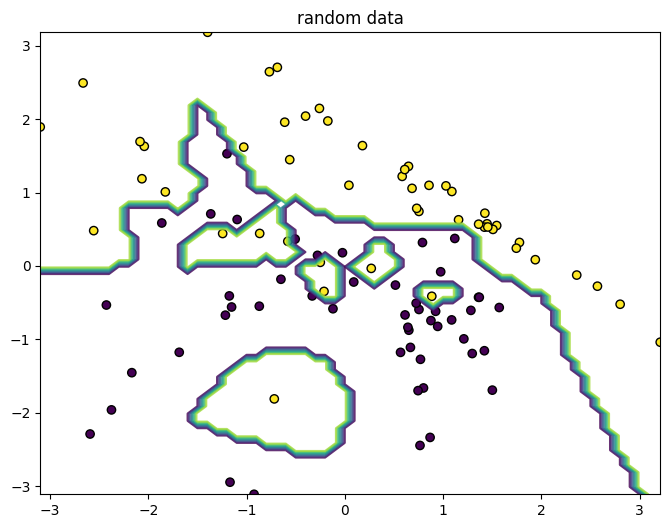

In [8]:
#klasyfikacja

X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=3)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

#krok
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

test = K_nn(n_neighbours = 1, use_KDTree = 1, what_task = 0)
test.fit(X,y)


points = np.vstack((xx.ravel(), yy.ravel())).T
Z = test.predict(points)
Z_reshaped = np.array(Z).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z_reshaped, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
plt.title('random data')
plt.savefig('random_data')
plt.show()

[[1]
 [1]
 [1]
 [1]
 [2]
 [0]
 [2]
 [2]
 [0]
 [2]
 [1]
 [2]
 [2]
 [2]
 [0]]
[2 1 1 1 2 0 2 2 0 2 1 2 2 2 0]


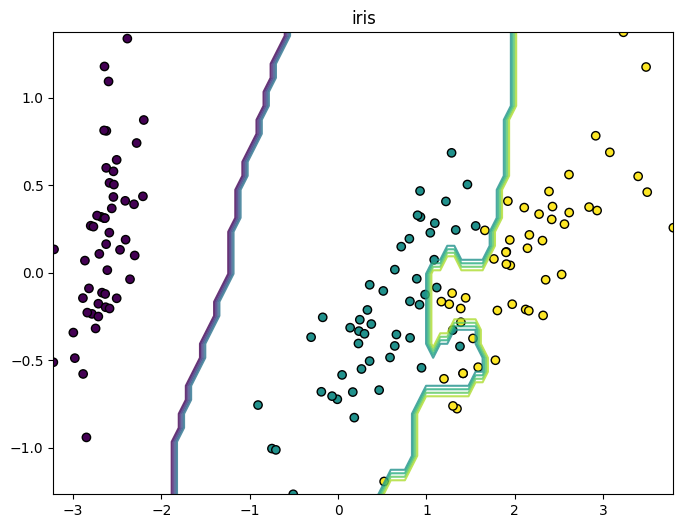

Bez drzewa!
Czas jaki zajęło szukanie błędów:  0.86s
k	Średni błąd klasyfikacji
1	0.0400
2	0.0533
4	0.0400
8	0.0333
16	0.0333
32	0.0467
64	0.0867
Z drzewem!
Czas jaki zajęło szukanie błędów:  0.30s
k	Średni błąd klasyfikacji
1	0.0400
2	0.0533
4	0.0400
8	0.0333
16	0.0333
32	0.0467
64	0.0867


In [9]:
#klasyfikacji ciąg dalszy

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import timeit

iris = load_iris()
X = iris.data
y = iris.target

Xtemp = iris.data
ytemp = iris.target

knn = K_nn(n_neighbours = 1, use_KDTree = 1, what_task = 0)
#knn.fit, jako zbiór treningowy daj losowe wybrane 10% irysów
random_indices = np.random.default_rng()
#losuję indeksy zbioru do klasyfikacji
chosen_indices = random_indices.choice(150, 15, replace=False)


X_test, y_test = X[chosen_indices], y[chosen_indices]
#usuwam wylosowane indeksy ze zbioru treningowego
X = np.delete(X, chosen_indices, axis=0)
y = np.delete(y, chosen_indices, axis=0)

knn.fit(X,y)
#korzystam z wycinka jako zbioru testowego
print(knn.predict(X_test))
print(y_test)

#zgodność!

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(Xtemp) #oryginalne niewycinane dane

#regularna siatka punktów

plt.figure(figsize=(8, 6))

x_min, x_max = X_train_2D[:, 0].min() - 0.1, X_train_2D[:, 0].max() + 0.1
y_min, y_max =X_train_2D[:, 1].min() - 0.1, X_train_2D[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.08), np.arange(y_min, y_max, 0.08))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_4D = pca.inverse_transform(grid_points)

Z = knn.predict(grid_points_4D)
Z = np.array(Z)
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=ytemp, edgecolors='k')
plt.xlim(np.min(X_train_2D[:, 0]), np.max(X_train_2D[:, 0]))
plt.ylim(np.min(X_train_2D[:, 1]), np.max(X_train_2D[:, 1]))
plt.title('iris')
plt.savefig('iris')
plt.show()

#LEAVE ONE OUT
for i in range(2):
  iris = load_iris()
  X = iris.data
  Y = iris.target

  loo = LeaveOneOut()
  n_values = [1, 2, 4, 8, 16, 32, 64]

  results = []
  if i == 0:
    print("Bez drzewa!")
  else:
    print("Z drzewem!")

  start_time = timeit.default_timer()
  for n in n_values:
    errors = np.ones(loo.get_n_splits(X))
    knn = K_nn(n_neighbours = n, use_KDTree = i, what_task = 0)
    for train_index, test_index in loo.split(X):

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        knn.fit(X_train, Y_train)
        prediction = knn.predict(X_test)
        error = np.mean(prediction != Y_test)
        errors[test_index] = error
    mean_error = np.mean(errors)
    results.append((n, mean_error))

  print("Czas jaki zajęło szukanie błędów: ", f"{(timeit.default_timer() - start_time):.2f}s",)
  print("k\tŚredni błąd klasyfikacji")
  for k, mean_error in results:
      print(f"{k}\t{mean_error:.4f}")

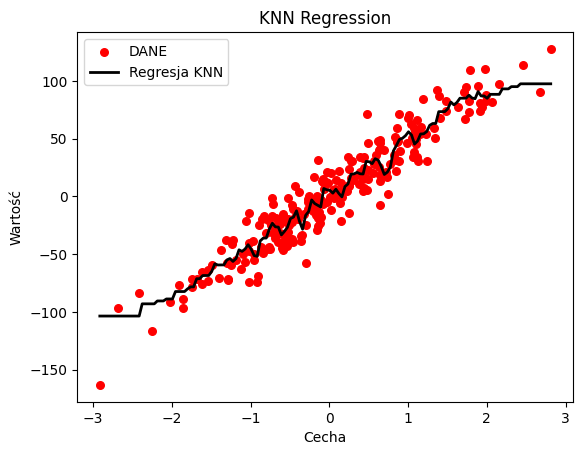

In [ ]:
#4 regresja

X, y = datasets.make_regression(n_samples=250, n_features=1, noise = 15, random_state=3)

knn = K_nn(7, 1, 1)
knn.fit(X,y)

x_range = np.linspace(np.min(X), np.max(X),150).reshape(-1, 1)
y_pred = knn.predict(x_range)

plt.scatter(X, y, color='red', s=30, marker='o', label='DANE')
plt.plot(x_range, y_pred, color='black', linewidth=2, label='Regresja KNN')
plt.xlabel('Cecha')
plt.ylabel('Wartość')
plt.title('KNN Regression')
plt.legend()
plt.savefig("Regresja KNN")
plt.show()


In [ ]:
#regresja kalifornia

from sklearn.datasets import fetch_california_housing
#import shutup # import to ignore HTTP 403 error fetch_california_housing
from sklearn.model_selection import KFold
import pandas as pd

#pobieramy dane
X, Y  = fetch_california_housing(return_X_y=True)

#krzyżowa walidacja, 10-krotna
kf = KFold(n_splits=10)
n_values = [1, 2, 4, 8, 16, 32, 64]

results = []

for n in n_values:
  #dla każdej liczby sąsiadów
  errors = np.zeros(kf.get_n_splits(X))

  knn = K_nn(n_neighbours = n, use_KDTree = 1, what_task = 1)
  #robimy 10-krotną walidację krzyżową
  for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    knn.fit(X_train, Y_train)
    prediction = knn.predict(X_test)

    error = knn.score(X_train, Y_train)
    errors[fold_index] = error

  #uśredniamy rezultaty i dołączamy do tabelki
  mean_error = np.mean(errors)
  results.append((n, mean_error))

results_df = pd.DataFrame(results, columns=['number of neighbours', 'MSE'])

print(results_df)

   number of neighbours       MSE
0                     1  1.000000
1                     2  0.709315
2                     4  0.514718
3                     8  0.370634
4                    16  0.263657
5                    32  0.172586
6                    64  0.102769
